In [27]:
import os
import sys
import pickle
import argparse
from scipy import sparse, io 
import numpy as np
import rpy2.robjects as robjects
import magic
import scprep
from sklearn.decomposition import NMF, non_negative_factorization, PCA
from sklearn.decomposition._nmf import _beta_divergence
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix 
import pylab 
import scipy.stats as stats



script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import simulate_multinomial_counts
from misc import *
from findK_correction_jk import *


import pdb

np.random.seed(123)

In [2]:
Yfile = "../../ebpmf_data_analysis/output/fastTopics_fit/sla_small.txt"
datafile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_fitted.Rds"
vocabfile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_vocab.txt"
titlefile="../../ebpmf_data_analysis/data/SLA/title.sla.txt"

## load data and fitted L, F, s
Y = io.mmread(Yfile)
vocab = np.loadtxt(vocabfile, dtype = str)
readRDS = robjects.r['readRDS']
data = readRDS(datafile)
w_idx = np.asarray(data.rx2('word_idx')).astype(int)
fitted = data.rx2('fit_sub')
F = np.asarray(fitted.rx2('F'))
L = np.asarray(fitted.rx2('L'))
s = np.asarray(fitted.rx2('s'))
p, k = F.shape
n = L.shape[0]

C = L @ F.T
C = C.T @ C / n
Cbar = C / C.sum(axis = 1)[:, None]
w_true = C.sum(axis = 1)

## get all true anchor words
a_words = {}
for k_ in range(k):
    a_words[k_] = np.where(find_anchor_word_k2(F, k_) == True)[0]


In [3]:
def simulate_multinomial_counts_local(L, F, s):
    n = L.shape[0]
    p = F.shape[0]
    Prob = L.dot(F.T)
    X = np.empty(shape = (n, p))
    for i in range(n):
        X[i,] = np.random.multinomial(s[i], Prob[i,], size = 1).astype(int)

    return X

def get_truth(Cbar, K):
    p = Cbar.shape[0]
    U = np.zeros((p, K))
    R = Cbar.T
    S = np.zeros(K)
    gs = np.zeros((p, K))
    g = (R**2).sum(axis = 0) 
    for k in range(K):
        gs[:, k] = g
        maxSquaredSum = np.max(g)
        maxCol = np.argmax(g)
        S[k] = maxCol
        u = R[:, maxCol].copy()
        u = u / np.sqrt(maxSquaredSum)
        U[:, k] = u
        R = R -  u[:, None] @ (u[:,None].T @ R)
        dg = (Cbar @ u)**2
        g -= dg        

    return S, U, gs

S, U, gs = get_truth(Cbar, k)
S

array([1669., 1888.,  178., 1666.,  490., 1933.])

## Magnitude of $(\theta_j, \text{se}(\hat{\theta_j}))$

* Note I throw away $\theta_j$ that are $0$. 

* Basically the mean is comparable to the SE. 

step 0


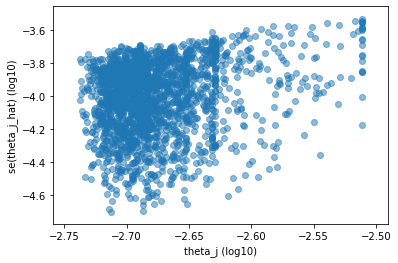

step 1


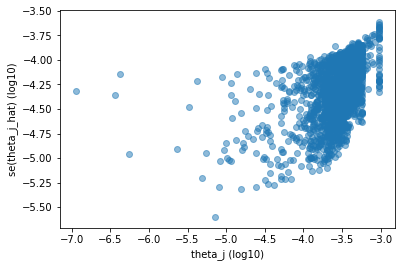

step 2


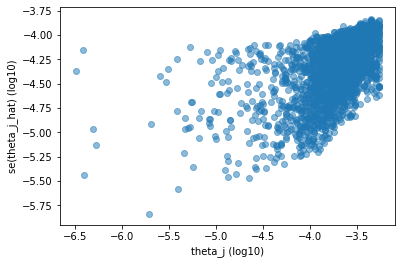

step 3


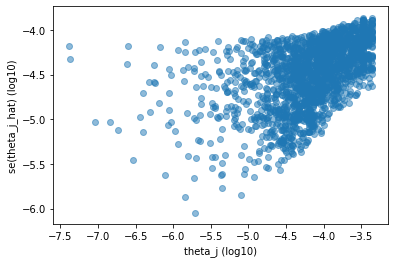

step 4


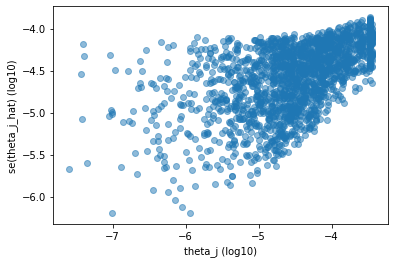

step 5


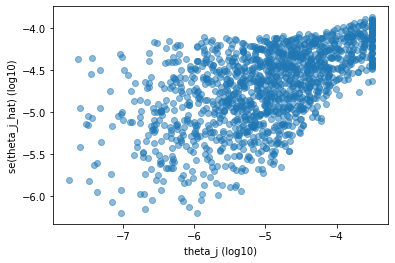

In [4]:
# outputfile="findK-exper-constd-jk2.pkl"
outputfile="findK-exper-jk2-bigger.pkl"
with open(outputfile, "rb") as f:
    tmp = pickle.load(f)

est = tmp['est']
se = tmp['se']
est_notcorrected = tmp['est_notcorrected']
for k_ in range(k):
    print(f"step {k_}")
    se_true = se[:, k_, :].mean(axis = 1)
    g_true = gs[:, k_]
    #plt.scatter(np.log10(g_true), np.log10(se_true))
    ix = np.where(g_true > 1e-8)
    plt.scatter(np.log10(g_true[ix]), np.log10(se_true[ix]), alpha = 0.5)
    plt.xlabel("theta_j (log10)")
    plt.ylabel("se(theta_j_hat) (log10)")
    plt.show()



## Compute $\gamma$

Check if my understanding of the definition is correct!

In [5]:
K = 6
k_ = 2
ind = np.ones(K, dtype=bool)
ind[k_] = False

U[:, ~ind].shape

(2062, 1)

In [6]:
def compute_gamma(U):
    K = U.shape[1]
    U_ = U.copy()
    gamma = -10
    for k_ in range(K):
        ind = np.ones(K, dtype=bool)
        ind[k_] = False
        x = U_[:, k_]
        val = (x**2).sum() - ((U_[:, ind].T @ x) ** 2).sum()
        val = np.sqrt(val)
        if val > gamma:
            gamma = val
    
    return gamma

compute_gamma(U)
        

1.0000000000000024

## relationship between $\text{se}(\hat{\theta}_j)$ and $p_j^{-\frac{1}{2}}$

My derivation says there should be a linear relationship  (at least for step 1). The plot below (both in log scale) has a slope of around $1$, so looks right! 

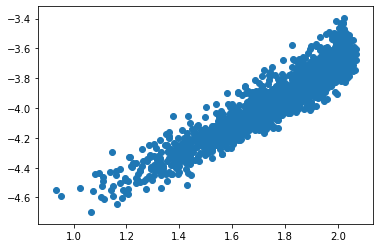

In [7]:
k_ = 0
est_ = est[:, k_,:].mean(axis = 1)
se_emp = np.sqrt(((est[:, k_, :] - est_[:, None])**2).mean(axis = 1))
se_ = se[:, k_, :].mean(axis = 1)
weights = C.sum(axis = 1)
weights_inv_sqrt = 1/np.sqrt(weights)


plt.scatter(np.log10(weights_inv_sqrt), np.log10(se_emp))
plt.show()

In [8]:
print((weights**2).sum())
print((F**2).sum(axis = 0))

0.0020597850380132433
[0.00514174 0.00643247 0.00325722 0.00339708 0.00289212 0.00401753]


In [9]:
(weights.max() * p, weights.min() * p)

(27.988274675614594, 0.15129424647853698)

In [10]:
for k_ in range(k):
    f = F[:, k_]
    print((f.max() * p, f.min() * p))
    

(67.29610978362803, 1.5451130019280157e-09)
(58.56581368500255, 1.1534198922740182e-09)
(31.312054223725493, 1.3251166000926802e-09)
(35.96643752997587, 1.2544293604523568e-09)
(44.37038686530669, 1.3583155889316043e-09)
(54.94672774999771, 1.1848782905495116e-09)


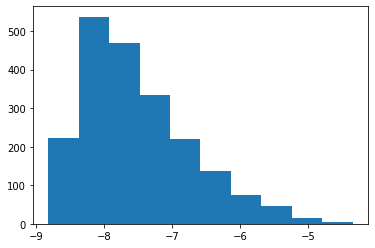

In [11]:
plt.hist(np.log10((F**2).mean(axis = 1) / k))
plt.show()

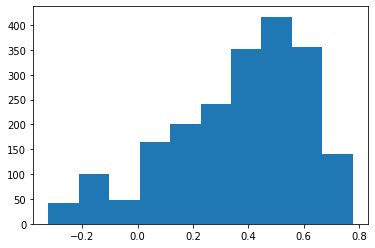

In [12]:
# plt.hist(2 * np.log10(weights) )
# plt.show()
plt.hist(2 * np.log10(weights) - np.log10((F**2).mean(axis = 1) / k))
plt.show()

## simulation

My guess is: for step 1
\begin{align}
& \sqrt{npd}(\hat{\theta} - \theta) \rightarrow N(0, D)\\
& d_{jj} \sim O(r_j^{-1})\\
& r_j := p p_j
\end{align}

In [72]:
n = 8000
p = 5000
d = 50
K = 50

# n = 10000
# p = 1000
# d = 50
# K = 50


outputfile=f"asymp_n{n}_p{p}_d{d}_K{K}.pkl"

with open(outputfile, 'rb') as f:
    data = pickle.load(f)
x = data['x']
r = data['r']
se = np.sqrt(((x - x.mean(axis = 1)[:, None])**2).mean(axis = 1))


## first check SE vs $r_j^{- 1/ 2}$

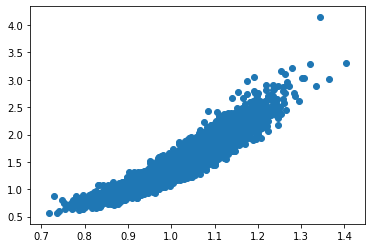

In [73]:
plt.scatter(np.sqrt(1/ r), se)
plt.show()

## check normality

Bias is not 0 !!

SE pattern is okay. 

0.5077607901192153


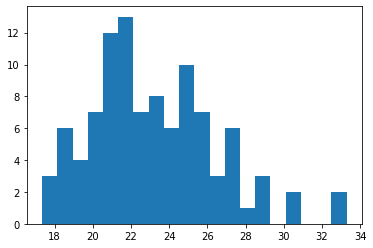

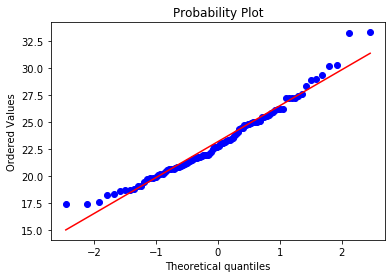

0.5365270176364656


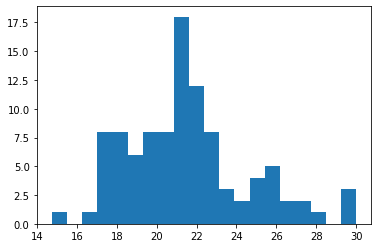

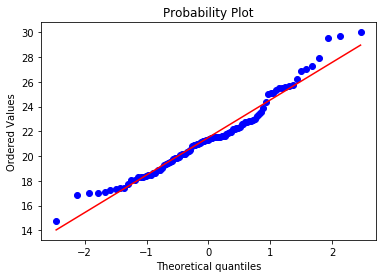

0.5533905197428437


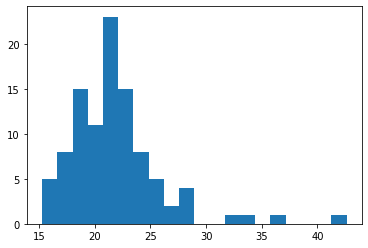

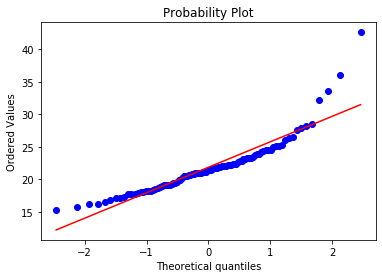

In [75]:
ix = np.argsort(r)[:3]

for i in ix:
    print(r[i])
    plt.hist(x[i, :], bins = 20)
    plt.show()


    stats.probplot(x[i, :], dist="norm", plot=pylab)
    pylab.show()

1.938421305929153


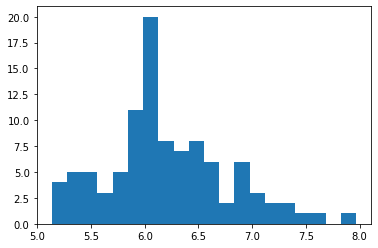

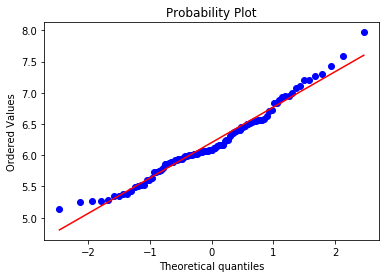

1.8757973131527985


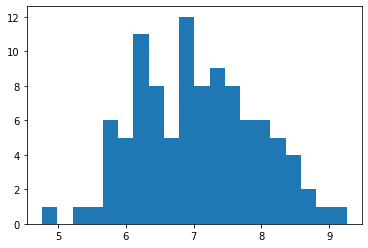

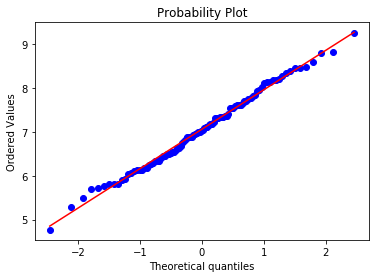

1.8468695558299997


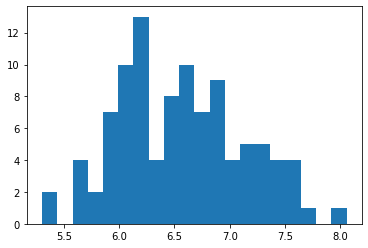

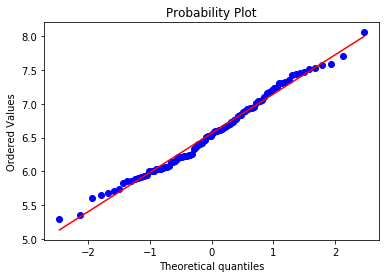

In [76]:
ix = np.argsort(-r)[:3]

for i in ix:
    print(r[i])
    plt.hist(x[i, :], bins = 20)
    plt.show()


    stats.probplot(x[i, :], dist="norm", plot=pylab)
    pylab.show()

## check correlation

In [70]:
n_offdiag = 10000
rhos = np.zeros(n_offdiag)
for i in range(n_offdiag):
    np.random.seed(i)
    j1, j2 = np.random.choice([i_ for i_ in range(p)], 2, replace = False)
    rho = (x[j1, :] * x[j2, :]).mean() - x[j1, :].mean() * x[j2, :].mean()
    rho /= (se[j1] * se[j2])
    rhos[i] = rho

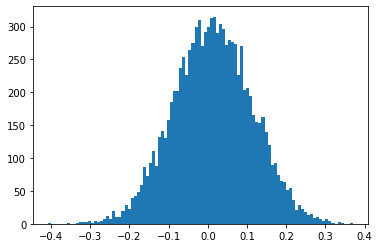

In [71]:
plt.hist(rhos, bins = 100)
plt.show()